In [1]:
# Load a pandas DataFrame
# Read data using pandas
import pandas as pd
import tensorflow as tf

SHUFFLE_BUFFER = 500
BATCH_SIZE = 2

# The heart disease dataset
csv_file = tf.keras.utils.get_file(
    "heart.csv",
    "https://storage.googleapis.com/download.tensorflow.org/data/heart.csv"
)

df = pd.read_csv(csv_file)
df.head()

13273/13273 [==============================] - 0s 0us/step


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


In [2]:
print(df.dtypes)

target = df.pop("target")

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal         object
target        int64
dtype: object


In [3]:
# A DataFrame as an array
numeric_feature_names = ["age", "thalach", "trestbps", "chol", "oldpeak"]
numeric_features = df[numeric_feature_names]
numeric_features.head()

,age,thalach,trestbps,chol,oldpeak
0,63,150,145,233,2.3
1,67,108,160,286,1.5
2,67,129,120,229,2.6
3,37,187,130,250,3.5
4,41,172,130,204,1.4


In [4]:
# Convert the values of the DataFrame to a tensor
tf.convert_to_tensor(numeric_features)

<tf.Tensor: shape=(303, 5), dtype=float64, numpy=
array([[ 63. , 150. , 145. , 233. ,   2.3],
       [ 67. , 108. , 160. , 286. ,   1.5],
       [ 67. , 129. , 120. , 229. ,   2.6],
       ...,
       [ 65. , 127. , 135. , 254. ,   2.8],
       [ 48. , 150. , 130. , 256. ,   0. ],
       [ 63. , 154. , 150. , 407. ,   4. ]])>

In [5]:
# With model.fit
# Normalize the input ranges
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(numeric_features)

# Visualize the first three rows of the DataFrame
normalizer(numeric_features.iloc[:3])

<tf.Tensor: shape=(3, 5), dtype=float32, numpy=
array([[ 0.93383914,  0.03480718,  0.74578077, -0.2600867 ,  1.0680453 ],
       [ 1.3782105 , -1.7806165 ,  1.5923285 ,  0.7573879 ,  0.38022864],
       [ 1.3782105 , -0.87290466, -0.6651321 , -0.3368772 ,  1.3259765 ]],
      dtype=float32)>

In [6]:
# Use the normalization layer as the first layer of a model
def get_basic_model():
    model = tf.keras.Sequential([
        normalizer,
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(1)
    ])

    model.compile(optimizer="adam",
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=["accuracy"])
    return model

model = get_basic_model()
model.fit(numeric_features, target, epochs=15, batch_size=BATCH_SIZE)

Epoch 1/15
152/152 [==============================] - 2s 3ms/step - loss: 0.6531 - accuracy: 0.7228
Epoch 2/15
152/152 [==============================] - 0s 3ms/step - loss: 0.5438 - accuracy: 0.7261
Epoch 3/15
152/152 [==============================] - 0s 3ms/step - loss: 0.4980 - accuracy: 0.7294
Epoch 4/15
152/152 [==============================] - 1s 3ms/step - loss: 0.4708 - accuracy: 0.7360
Epoch 5/15
152/152 [==============================] - 0s 3ms/step - loss: 0.4511 - accuracy: 0.7591
Epoch 6/15
152/152 [==============================] - 0s 3ms/step - loss: 0.4399 - accuracy: 0.7723
Epoch 7/15
152/152 [==============================] - 0s 3ms/step - loss: 0.4350 - accuracy: 0.7822
Epoch 8/15
152/152 [==============================] - 0s 2ms/step - loss: 0.4294 - accuracy: 0.7888
Epoch 9/15
152/152 [==============================] - 0s 2ms/step - loss: 0.4263 - accuracy: 0.7888
Epoch 10/15
152/152 [==============================] - 0s 2ms/step - loss: 0.4252 - accuracy: 0.7855

In [7]:
# With tf.data
# Create a dataset that iterates over the rows of the DataFrame
numeric_dataset = tf.data.Dataset.from_tensor_slices(
    (numeric_features, target)
)

for row in numeric_dataset.take(3):
    print(row)

(<tf.Tensor: shape=(5,), dtype=float64, numpy=array([ 63. , 150. , 145. , 233. ,   2.3])>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
(<tf.Tensor: shape=(5,), dtype=float64, numpy=array([ 67. , 108. , 160. , 286. ,   1.5])>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
(<tf.Tensor: shape=(5,), dtype=float64, numpy=array([ 67. , 129. , 120. , 229. ,   2.6])>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)


In [8]:
numeric_batches = numeric_dataset.shuffle(1000).batch(BATCH_SIZE)

model = get_basic_model()
model.fit(numeric_batches, epochs=15)

Epoch 1/15
152/152 [==============================] - 1s 2ms/step - loss: 0.6398 - accuracy: 0.7261
Epoch 2/15
152/152 [==============================] - 0s 2ms/step - loss: 0.5645 - accuracy: 0.7261
Epoch 3/15
152/152 [==============================] - 1s 3ms/step - loss: 0.5249 - accuracy: 0.7261
Epoch 4/15
152/152 [==============================] - 0s 3ms/step - loss: 0.5024 - accuracy: 0.7261
Epoch 5/15
152/152 [==============================] - 0s 2ms/step - loss: 0.4901 - accuracy: 0.7261
Epoch 6/15
152/152 [==============================] - 0s 2ms/step - loss: 0.4810 - accuracy: 0.7261
Epoch 7/15
152/152 [==============================] - 0s 3ms/step - loss: 0.4751 - accuracy: 0.7261
Epoch 8/15
152/152 [==============================] - 0s 3ms/step - loss: 0.4705 - accuracy: 0.7261
Epoch 9/15
152/152 [==============================] - 0s 2ms/step - loss: 0.4660 - accuracy: 0.7261
Epoch 10/15
152/152 [==============================] - 0s 2ms/step - loss: 0.4616 - accuracy: 0.7261

In [10]:
# A DataFrame as a dictionaryo
numeric_dict_ds = tf.data.Dataset.from_tensor_slices(
    (dict(numeric_features), target)
)

for row in numeric_dict_ds.take(3):
    print(row)

({'age': <tf.Tensor: shape=(), dtype=int64, numpy=63>, 'thalach': <tf.Tensor: shape=(), dtype=int64, numpy=150>, 'trestbps': <tf.Tensor: shape=(), dtype=int64, numpy=145>, 'chol': <tf.Tensor: shape=(), dtype=int64, numpy=233>, 'oldpeak': <tf.Tensor: shape=(), dtype=float64, numpy=2.3>}, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
({'age': <tf.Tensor: shape=(), dtype=int64, numpy=67>, 'thalach': <tf.Tensor: shape=(), dtype=int64, numpy=108>, 'trestbps': <tf.Tensor: shape=(), dtype=int64, numpy=160>, 'chol': <tf.Tensor: shape=(), dtype=int64, numpy=286>, 'oldpeak': <tf.Tensor: shape=(), dtype=float64, numpy=1.5>}, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
({'age': <tf.Tensor: shape=(), dtype=int64, numpy=67>, 'thalach': <tf.Tensor: shape=(), dtype=int64, numpy=129>, 'trestbps': <tf.Tensor: shape=(), dtype=int64, numpy=120>, 'chol': <tf.Tensor: shape=(), dtype=int64, numpy=229>, 'oldpeak': <tf.Tensor: shape=(), dtype=float64, numpy=2.6>}, <tf.Tensor: shape=(), dtype=int64, numpy=0>)


In [12]:
# Dictionaries with Keras

# 1. The model-subclass style
def stack_dict(inputs, fun=tf.stack):
    values = []
    for key in sorted(inputs.keys()):
        values.append(tf.cast(inputs[key], tf.float32))

    return fun(values, axis=-1)

class MyModel(tf.keras.Model):
    def __init__(self):
        # Create all the internal layers in init
        super().__init__()

        self.normalizer = tf.keras.layers.Normalization(axis=-1)

        self.seq = tf.keras.Sequential([
            self.normalizer,
            tf.keras.layers.Dense(10, activation="relu"),
            tf.keras.layers.Dense(10, activation="relu"),
            tf.keras.layers.Dense(1)
        ])

    def adapt(self, inputs):
        # Stack the inputs and `adapt` the normalization layer
        inputs = stack_dict(inputs)
        self.normalizer.adapt(inputs)

    def call(self, inputs):
        # Stack the inputs
        inputs = stack_dict(inputs)
        # Run them through all the layers
        result = self.seq(inputs)

        return result


model = MyModel()

model.adapt(dict(numeric_features))

model.compile(optimizer="adam",
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"],
              run_eagerly=True)

In [13]:
# Train with a dictionary of columns
model.fit(dict(numeric_features), target, epochs=5, batch_size=BATCH_SIZE)

Epoch 1/5
152/152 [==============================] - 6s 40ms/step - loss: 0.6238 - accuracy: 0.7261
Epoch 2/5
152/152 [==============================] - 7s 46ms/step - loss: 0.5319 - accuracy: 0.7261
Epoch 3/5
152/152 [==============================] - 6s 40ms/step - loss: 0.4895 - accuracy: 0.7261
Epoch 4/5
152/152 [==============================] - 9s 62ms/step - loss: 0.4703 - accuracy: 0.7261
Epoch 5/5
152/152 [==============================] - 13s 84ms/step - loss: 0.4610 - accuracy: 0.7261


In [14]:
# Train with a dataset of dictionary-elements
numeric_dict_batches = numeric_dict_ds.shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE)
model.fit(numeric_dict_batches, epochs=5)

Epoch 1/5
152/152 [==============================] - 5s 32ms/step - loss: 0.4553 - accuracy: 0.7261
Epoch 2/5
152/152 [==============================] - 5s 34ms/step - loss: 0.4511 - accuracy: 0.7327
Epoch 3/5
152/152 [==============================] - 5s 33ms/step - loss: 0.4465 - accuracy: 0.7426
Epoch 4/5
152/152 [==============================] - 6s 40ms/step - loss: 0.4424 - accuracy: 0.7459
Epoch 5/5
152/152 [==============================] - 5s 33ms/step - loss: 0.4399 - accuracy: 0.7525


In [15]:
# Predict with the first three examples
model.predict(dict(numeric_features.iloc[:3]))

1/1 [==============================] - 0s 76ms/step


array([[[0.11037241]],

       [[0.77290475]],

       [[0.0074464 ]]], dtype=float32)

In [16]:
# 2. the Keras functional style
inputs = {}
for name, column in numeric_features.items():
    inputs[name] = tf.keras.Input(
        shape=(1,), name=name, dtype=tf.float32
    )

print(inputs)

{'age': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'age')>, 'thalach': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'thalach')>, 'trestbps': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'trestbps')>, 'chol': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'chol')>, 'oldpeak': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'oldpeak')>}


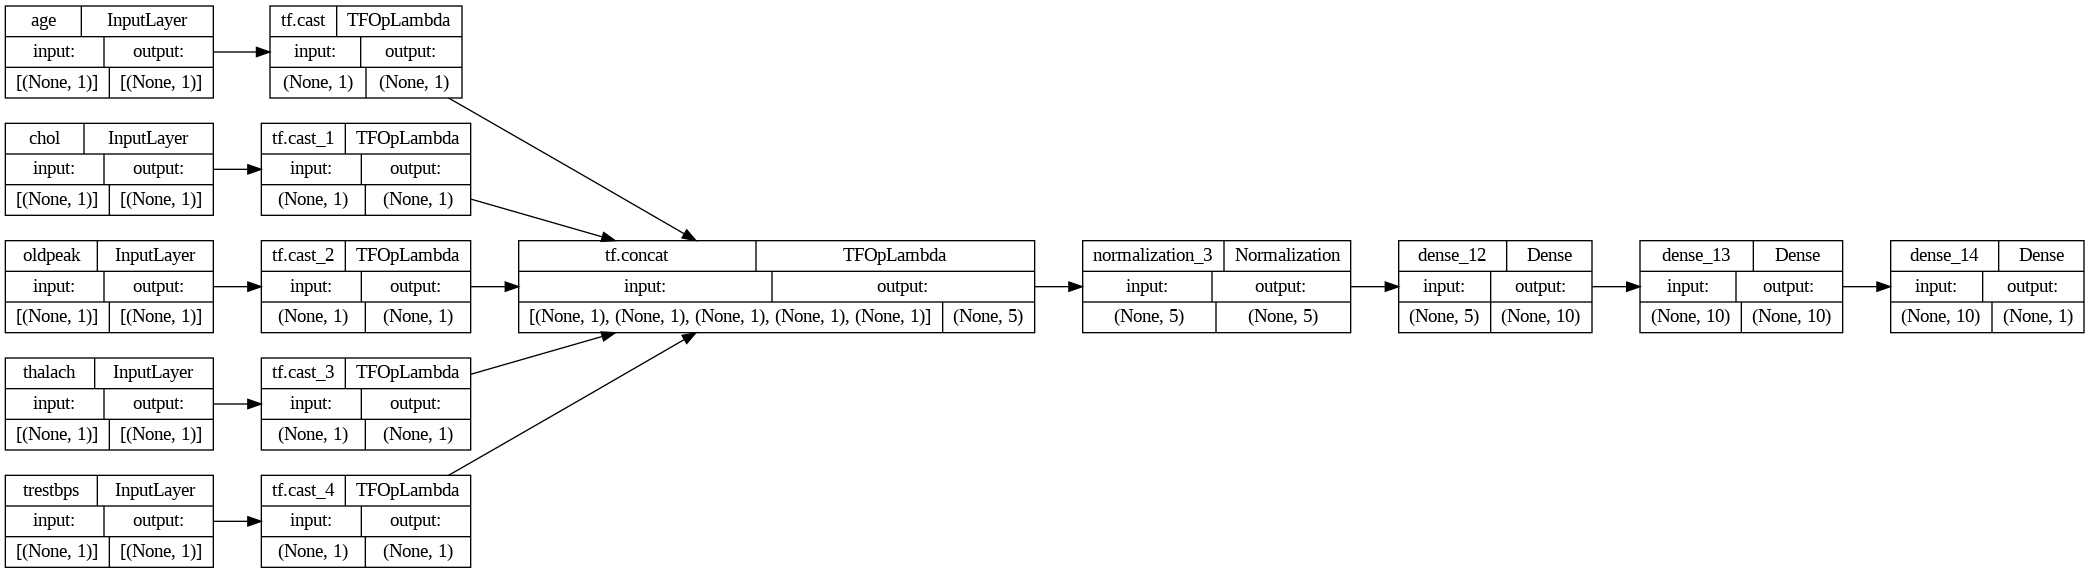

In [17]:
x = stack_dict(inputs, fun=tf.concat)

normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(stack_dict(numeric_features))

x = normalizer(x)
x = tf.keras.layers.Dense(10, activation="relu")(x)
x = tf.keras.layers.Dense(10, activation="relu")(x)
x = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(inputs, x)

model.compile(optimizer="adam",
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"],
              run_eagerly=True)

tf.keras.utils.plot_model(model, rankdir="LR", show_shapes=True)

In [18]:
# Train the functional model
# with a dictionary of columns
model.fit(dict(numeric_features), target, epochs=5, batch_size=BATCH_SIZE)

Epoch 1/5
152/152 [==============================] - 6s 41ms/step - loss: 0.6646 - accuracy: 0.6997
Epoch 2/5
152/152 [==============================] - 5s 35ms/step - loss: 0.5426 - accuracy: 0.7195
Epoch 3/5
152/152 [==============================] - 6s 43ms/step - loss: 0.4932 - accuracy: 0.7261
Epoch 4/5
152/152 [==============================] - 5s 36ms/step - loss: 0.4739 - accuracy: 0.7327
Epoch 5/5
152/152 [==============================] - 7s 43ms/step - loss: 0.4645 - accuracy: 0.7327


In [19]:
# Train with a dataset of dictionary-elements
numeric_dict_batches = numeric_dict_ds.shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE)
model.fit(numeric_dict_batches, epochs=5)

Epoch 1/5
152/152 [==============================] - 7s 43ms/step - loss: 0.4590 - accuracy: 0.7393
Epoch 2/5
152/152 [==============================] - 6s 36ms/step - loss: 0.4536 - accuracy: 0.7459
Epoch 3/5
152/152 [==============================] - 7s 43ms/step - loss: 0.4483 - accuracy: 0.7558
Epoch 4/5
152/152 [==============================] - 6s 39ms/step - loss: 0.4441 - accuracy: 0.7624
Epoch 5/5
152/152 [==============================] - 6s 37ms/step - loss: 0.4414 - accuracy: 0.7690


In [ ]:
# Build the preprocessing head
# List of the features that fall into each group
binary_feature_names = ["sex", "fbs", "exang"]
categorical_feature_names = ["cp", "restecg", "slope", "thal", "ca"]

In [21]:
# Create one tf.keras.Input for each column of the dataframe
inputs = {}
for name, column in df.items():
    if type(column[0]) == str:
        dtype = tf.string
    elif (name in categorical_feature_names or
          name in binary_feature_names):
        dtype = tf.int64
    else:
        dtype = tf.float32

    inputs[name] = tf.keras.Input(shape=(), name=name, dtype=dtype)

print(inputs)

{'age': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'age')>, 'sex': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'sex')>, 'cp': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'cp')>, 'trestbps': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'trestbps')>, 'chol': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'chol')>, 'fbs': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'fbs')>, 'restecg': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'restecg')>, 'thalach': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'thalach')>, 'exang': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'exang')>, 'oldpeak': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'oldpeak')>, 'slope': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'slope')>, 'ca': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'ca')>, 'thal': <KerasTensor: shape=(None,) dtype=string (created by 

In [22]:
# Binary inputs:
# just add the vector axis, cast them to float32 and add them to the list of
# preprocessed inputs
preprocessed = []

for name in binary_feature_names:
    inp = inputs[name]
    inp = inp[:, tf.newaxis]
    float_value = tf.cast(inp, tf.float32)
    preprocessed.append(float_value)

print(preprocessed)

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_5')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_6')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_7')>]


In [23]:
# Numeric inputs: normalize before using them
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(stack_dict(dict(numeric_features)))

numeric_inputs = {}
for name in numeric_feature_names:
    numeric_inputs[name] = inputs[name]

numeric_inputs = stack_dict(numeric_inputs)
numeric_normalized = normalizer(numeric_inputs)

preprocessed.append(numeric_normalized)

print(preprocessed)

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_5')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_6')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_7')>, <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'normalization_4')>]


In [24]:
# Categorical features:
# encode them into either binary vectors or embeddings
vocab = ["a", "b", "c"]
lookup = tf.keras.layers.StringLookup(vocabulary=vocab, output_mode="one_hot")
lookup(["c", "a", "a", "b", "zzz"])

<tf.Tensor: shape=(5, 4), dtype=float32, numpy=
array([[0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.]], dtype=float32)>

In [25]:
vocab = [1, 4, 7, 99]
lookup = tf.keras.layers.IntegerLookup(vocabulary=vocab, output_mode="one_hot")

lookup([-1, 4, 1])

<tf.Tensor: shape=(3, 5), dtype=float32, numpy=
array([[1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)>

In [27]:
# Convert the vocabulary to a one-hot vector
for name in categorical_feature_names:
    vocab = sorted(set(df[name]))
    print(f"name: {name}")
    print(f"vocab: {vocab}\n")

    if type(vocab[0]) is str:
        lookup = tf.keras.layers.StringLookup(
            vocabulary=vocab, output_mode="one_hot"
        )
    else:
        lookup = tf.keras.layers.IntegerLookup(
            vocabulary=vocab, output_mode="one_hot"
        )

    x = inputs[name][:, tf.newaxis]
    x = lookup(x)
    preprocessed.append(x)

name: cp
vocab: [0, 1, 2, 3, 4]

name: restecg
vocab: [0, 1, 2]

name: slope
vocab: [1, 2, 3]

name: thal
vocab: ['1', '2', 'fixed', 'normal', 'reversible']

name: ca
vocab: [0, 1, 2, 3]



[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_5')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_6')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_7')>, <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'normalization_4')>, <KerasTensor: shape=(None, 6) dtype=float32 (created by layer 'integer_lookup_1')>, <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'integer_lookup_2')>, <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'integer_lookup_3')>, <KerasTensor: shape=(None, 6) dtype=float32 (created by layer 'string_lookup_1')>, <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'integer_lookup_4')>]
KerasTensor(type_spec=TensorSpec(shape=(None, 33), dtype=tf.float32, name=None), name='tf.concat_1/concat:0', description="created by layer 'tf.concat_1'")


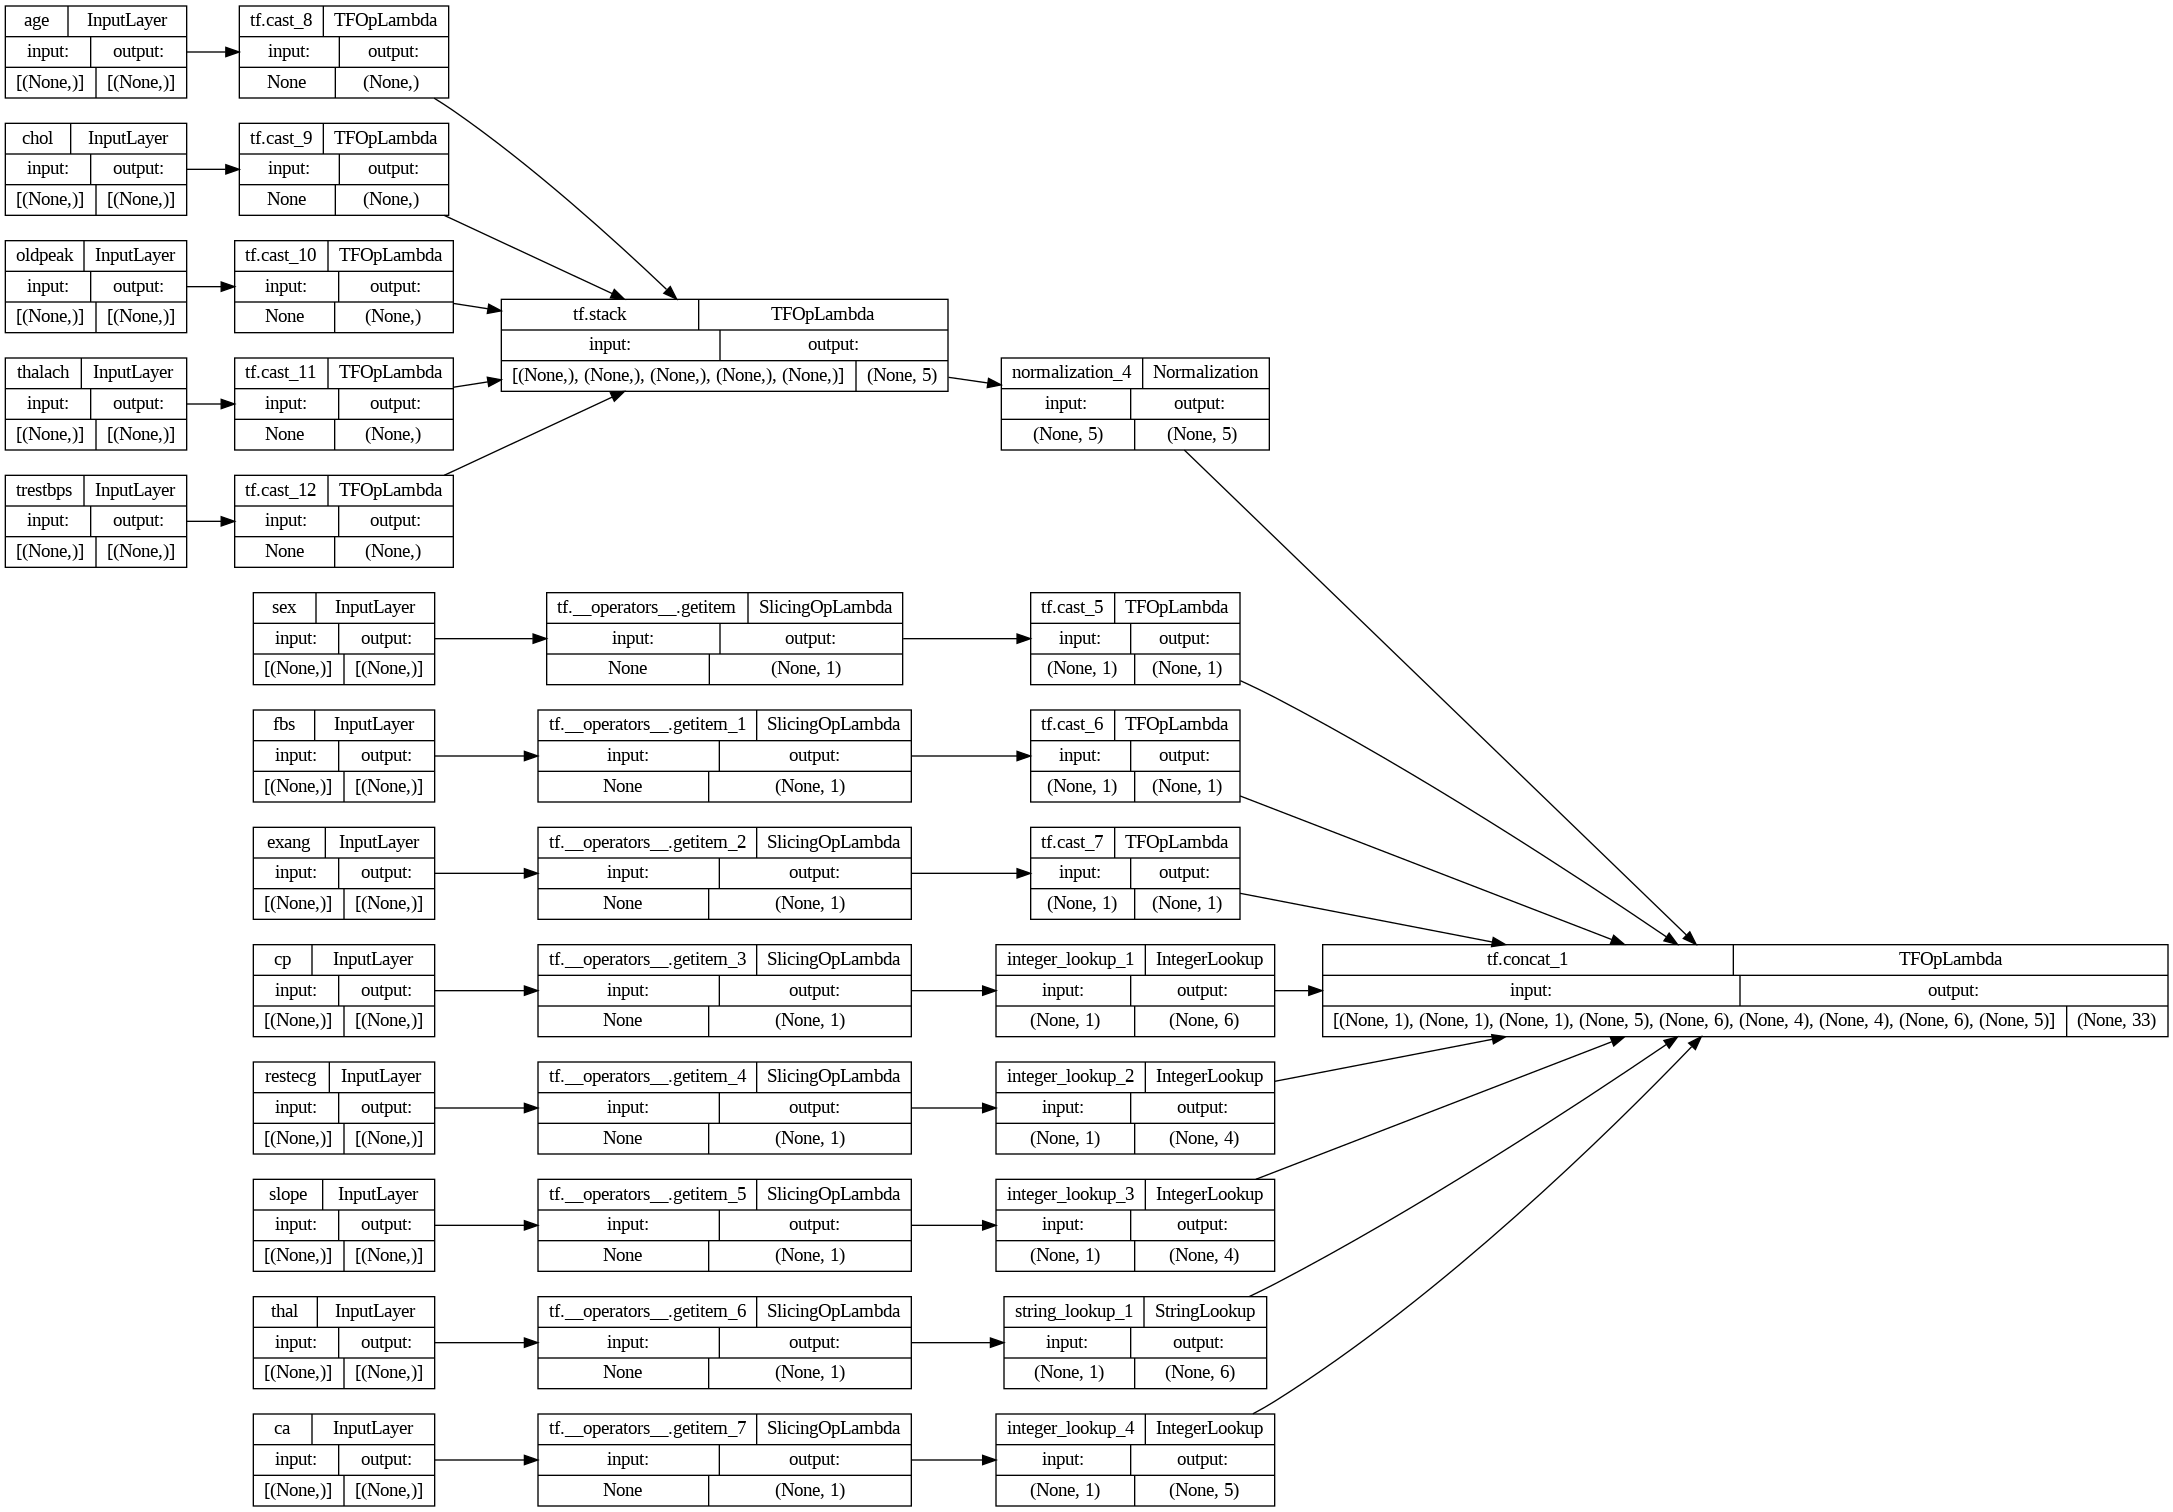

In [28]:
# Assemble the preprocessing head
print(preprocessed)

# Concatenate all the preprocessed features along the `depth` axis
preprocessed_result = tf.concat(preprocessed, axis=-1)
print(preprocessed_result)

# Create a model out of that calculation
preprocessor = tf.keras.Model(inputs, preprocessed_result)

tf.keras.utils.plot_model(preprocessor, rankdir="LR", show_shapes=True)

In [29]:
# Preprocess the first example from the DataFrame
preprocessor(dict(df.iloc[:1]))

<tf.Tensor: shape=(1, 33), dtype=float32, numpy=
array([[ 1.        ,  1.        ,  0.        ,  0.93383914, -0.2600867 ,
         1.0680453 ,  0.03480718,  0.74578077,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ]], dtype=float32)>

In [31]:
# Create and train a model
body = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
])

print(inputs)

x = preprocessor(inputs)
print(x)

result = body(x)
print(result)

model = tf.keras.Model(inputs, result)

model.compile(optimizer="adam",
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

history = model.fit(dict(df), target, epochs=5, batch_size=BATCH_SIZE)

{'age': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'age')>, 'sex': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'sex')>, 'cp': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'cp')>, 'trestbps': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'trestbps')>, 'chol': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'chol')>, 'fbs': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'fbs')>, 'restecg': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'restecg')>, 'thalach': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'thalach')>, 'exang': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'exang')>, 'oldpeak': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'oldpeak')>, 'slope': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'slope')>, 'ca': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'ca')>, 'thal': <KerasTensor: shape=(None,) dtype=string (created by 

In [33]:
# Using `tf.data` works as well
ds = tf.data.Dataset.from_tensor_slices((dict(df), target))
ds = ds.batch(BATCH_SIZE)

import pprint

for x, y in ds.take(1):
    pprint.pprint(x)
    print()
    print(y)

history = model.fit(ds, epochs=5)

{'age': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([63, 67])>,
 'ca': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([0, 3])>,
 'chol': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([233, 286])>,
 'cp': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([1, 4])>,
 'exang': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([0, 1])>,
 'fbs': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([1, 0])>,
 'oldpeak': <tf.Tensor: shape=(2,), dtype=float64, numpy=array([2.3, 1.5])>,
 'restecg': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([2, 2])>,
 'sex': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([1, 1])>,
 'slope': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([3, 2])>,
 'thal': <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'fixed', b'normal'], dtype=object)>,
 'thalach': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([150, 108])>,
 'trestbps': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([145, 160])>}

tf.Tensor([0 1], shape=(2,), dtype=int64)
Epoch 1/5
152/1